![Pytorch](../../../pytorch_logo_2018.svg)

# Pytorch 高级篇（3）：神经风格迁移（Neural Style Transfer）

>参考代码
>
>**yunjey的 [pytorch tutorial系列](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/neural_style_transfer)**

## 神经风格迁移 学习资料

>**相关文献**
>
>[Neural Style Transfer: A Review](https://arxiv.org/abs/1705.04058)
>
>上文的中文解读: [神经风格迁移研究概述：从当前研究到未来方向](https://zhuanlan.zhihu.com/p/26913182)

>**视频讲解**
>
>[8分钟如何理解neural style transfer的模型和损失函数](https://www.bilibili.com/video/av22581633/?p=41)

>**关于VGG-19网络**
>
>[利用卷积神经网络(VGG19)实现火灾分类(附tensorflow代码及训练集)](http://www.cnblogs.com/vipyoumay/p/7884472.html)

## Pytorch 实现


### 预处理

In [5]:
# 包
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

In [6]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 图像加载函数

In [7]:
# 图像加载函数
def load_image(image_path, transform=None, max_size=None, shape=None):
    """加载图像，并进行Resize、transform操作"""
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

### 模型加载

这次实验用的CNN模型是VGG-19。

CNN模型是用来提取特征使用的，风格迁移过程中并不需要对其进行优化。

In [9]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        # 选择conv_1到conv_5的激活图
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        # 提取多卷积特征图
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


### 处理流程函数

In [12]:
def transfer(config):
    
    # 图像处理
    # VGGNet在ImageNet数据集上训练的，ImageNet的图像已被归一化为mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # 这里也进行使用同样的数据进行归一化
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # 加载待转换的内容图像content和目标风格图像style
    # 两者的大小需要相同
    content = load_image(config.content, transform, max_size=config.max_size)
    style = load_image(config.style, transform, shape=[content.size(2), content.size(3)])
    
    # Initialize a target image with the content image
    #  用content图像初始化一个target图像
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=config.lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval() # 切换到eval()模式，省去梯度计算量
    
    for step in range(config.total_step):
        
        # Extract multiple(5) conv feature vectors
        # 提取多层特征向量
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            # 计算content损失：target - content
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            # Reshape 卷积特征图
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            # 计算Gram矩阵（格拉姆矩阵）
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            # 计算style损失：tartget - style
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        # 计算全部损失，并进行反向传播和优化
        loss = content_loss + config.style_weight * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config.log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, config.total_step, content_loss.item(), style_loss.item()))

        if (step+1) % config.sample_step == 0:
            # Save the generated image
            # 采样保存生成的风格图像
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

### 运行代码，进行风格迁移

In [28]:
# argparse是一个命令行解析包，可以用来进行命令参数的设置
# 以往的超参数设置可以通过传递命令参数的方式实现
parser = argparse.ArgumentParser()
parser.add_argument('--content', type=str, default='content.jpg')
parser.add_argument('--style', type=str, default='style.jpg')
parser.add_argument('--max_size', type=int, default=400)
parser.add_argument('--total_step', type=int, default=5000)
parser.add_argument('--log_step', type=int, default=50)
parser.add_argument('--sample_step', type=int, default=500)
parser.add_argument('--style_weight', type=float, default=100)
parser.add_argument('--lr', type=float, default=0.003)

config = parser.parse_args(args=[]) # 合成命令 # 注意jupyter中需要注意无参数则添加args=[]这句话
print(config)

transfer(config) # 运行风格迁移函数

Namespace(content='content.jpg', log_step=50, lr=0.003, max_size=400, sample_step=500, style='style.jpg', style_weight=100, total_step=5000)
Step [50/5000], Content Loss: 24.2413, Style Loss: 574.5425
Step [100/5000], Content Loss: 32.4526, Style Loss: 339.3264
Step [150/5000], Content Loss: 36.3637, Style Loss: 249.3080
Step [200/5000], Content Loss: 38.6992, Style Loss: 201.1833
Step [250/5000], Content Loss: 40.4127, Style Loss: 169.7927
Step [300/5000], Content Loss: 41.7685, Style Loss: 147.1366
Step [350/5000], Content Loss: 42.9247, Style Loss: 129.5607
Step [400/5000], Content Loss: 43.9380, Style Loss: 115.4246
Step [450/5000], Content Loss: 44.8378, Style Loss: 103.7703
Step [500/5000], Content Loss: 45.6480, Style Loss: 93.9557
Step [550/5000], Content Loss: 46.3671, Style Loss: 85.6205
Step [600/5000], Content Loss: 47.0299, Style Loss: 78.4145
Step [650/5000], Content Loss: 47.6382, Style Loss: 72.1611
Step [700/5000], Content Loss: 48.2043, Style Loss: 66.7238
Step [750/5

### 结果展示

In [29]:
#导入包
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#### content图像和style图像

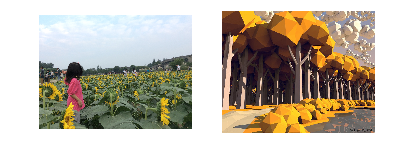

In [32]:
content= './content.jpg'
contentImg = mpimg.imread(content)

style = './style.jpg'
styleImg = mpimg.imread(style)

plt.figure()
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(contentImg) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(styleImg) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


####  迁移结果(训练第500次和第5000次)

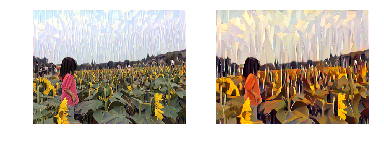

In [33]:
trans1= './output-500.png'
trans1Img = mpimg.imread(trans1)

trans2 = './output-5000.png'
trans2Img = mpimg.imread(trans2)

plt.figure()
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(trans1Img) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(trans2Img) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()